# NLP Predicts Programming Language of a Github Repo

## Goal

The primary goal for this project was to build an NLP model that can predict the primary language of REPO using the text in the README file.

As a secondary goal, we decided to pull repos from a specific sector, or topic, to see if an industry we were interested is utilizing a program language we're familiar with.

Due to the first and second goals, this repo can be used as a means to research an potenial industry you might be interested in entering, and knowing what programming language you'll need to have familiarity with.

## Data Dictionary

**language**: Programming language used for repositort project

**category**: The category within the energy sector

**repo**: The specific repo referenced with that observation

**readme_contents**: Description of each repository containing keywords used to make predictions

**clean_tokes**: README content normalized removing any uppercased characters, special characters, non-alpha characters, and alpha strings with 2 or less characters

**clean_stemmed**: README content reducing each word to its root stem and then removes any stopwords

**clean_lemmatized**: README content reducing each word to its root word and then removes any stopwords

**word_count**: The total word count for that observation

In [1]:
# Base 
import pandas as pd
import numpy as np
import re
from pprint import pprint
from scipy import stats

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# scraping modules
from requests import get
from bs4 import BeautifulSoup
import unicodedata

# NLP
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Functions, etc.
import os
from os import path
import acquire
import prepare

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(16, 9))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

import warnings
warnings.filterwarnings("ignore")

## Acquire our data

In [2]:
# The code below sets the table by creating a json file per parameter in acquire_repo_list

# acquire.acquire_repo_list('gasoline')
# acquire.acquire_repo_list('solar energy')
# acquire.acquire_repo_list('wind power')

# The we take those json files and use them to scrape our data

# df = acquire.scrape_github_data()

# Then we make a DataFrame proper from that work, and save it as a csv.

# pd.DataFrame(df).to_csv('new_repos_dict.csv', index=False)

# Then we read the csv in

df = pd.read_csv('new_repos_dict.csv')

# Then we create a category for each observation

df.loc[:200, 'category'] = 'gasoline'
df.loc[200:400, 'category'] = 'wind_energy'
df.loc[400:, 'category'] = 'solar_power'

df.head()

,repo,language,readme_contents,category
0,N-BodyShop/gasoline,C,```\n \t ▄████ ▄▄▄ ██████ ▒█████ █...,gasoline
1,michipili/gasoline,OCaml,# Gasoline\n\nThe Gasoline project aims at imp...,gasoline
2,rvikmanis/gasoline,TypeScript,# Gasoline\n\nConvenient state container for R...,gasoline
3,iggisv9t/benzin_gif,Python,# benzin_gif\nCreate animated gifs that looks ...,gasoline
4,daneharrigan/gasoline,Go,# gasoline\n\n![Gasoline Dashboard](http://cl....,gasoline


## Prepare our data

In [3]:
# We run the prepare function from our prepare.py file

df = prepare.prep_repo_data(df)

In [4]:
df.head()

,language,category,repo,readme_contents,clean_tokes,clean_stemmed,clean_lemmatized
0,C,gasoline,N-BodyShop/gasoline,```\n \t ▄████ ▄▄▄ ██████ ▒█████ █...,"[&#9;, &#9;, &#9;, &#9;, &#9;, &#9;, &#9;, &#9...",&#9; &#9; &#9; &#9; &#9; &#9; &#9; &#9; &#9; g...,&#9; &#9; &#9; &#9; &#9; &#9; &#9; &#9; &#9; g...
1,OCaml,gasoline,michipili/gasoline,# Gasoline\n\nThe Gasoline project aims at imp...,"[gasoline, the, gasoline, project, aims, at, i...",gasolin gasolin project aim implement unixish ...,gasoline gasoline project aim implementing uni...
2,TypeScript,gasoline,rvikmanis/gasoline,# Gasoline\n\nConvenient state container for R...,"[gasoline, convenient, state, container, for, ...",gasolin conveni state contain react instal npm...,gasoline convenient state container react inst...
3,Python,gasoline,iggisv9t/benzin_gif,# benzin_gif\nCreate animated gifs that looks ...,"[benzin_gif, create, animated, gifs, that, loo...",benzin_gif creat anim gif look like gasolin pu...,benzin_gif create animated gifs look like gaso...
4,Go,gasoline,daneharrigan/gasoline,# gasoline\n\n![Gasoline Dashboard](http://cl....,"[gasoline, gasoline, dashboardhttpcllyimage3l1...",gasolin gasolin dashboardhttpcllyimage3l190u3q...,gasoline gasoline dashboardhttpcllyimage3l190u...


In [5]:
# We notice some nulls

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445 entries, 0 to 599
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   language          411 non-null    object
 1   category          445 non-null    object
 2   repo              445 non-null    object
 3   readme_contents   443 non-null    object
 4   clean_tokes       445 non-null    object
 5   clean_stemmed     445 non-null    object
 6   clean_lemmatized  445 non-null    object
dtypes: object(7)
memory usage: 27.8+ KB


In [6]:
# Drop the nulls

df.dropna(inplace=True)

In [7]:
# Reset the index

df.reset_index(drop=True, inplace=True)

In [8]:
df.head()

,language,category,repo,readme_contents,clean_tokes,clean_stemmed,clean_lemmatized
0,C,gasoline,N-BodyShop/gasoline,```\n \t ▄████ ▄▄▄ ██████ ▒█████ █...,"[&#9;, &#9;, &#9;, &#9;, &#9;, &#9;, &#9;, &#9...",&#9; &#9; &#9; &#9; &#9; &#9; &#9; &#9; &#9; g...,&#9; &#9; &#9; &#9; &#9; &#9; &#9; &#9; &#9; g...
1,OCaml,gasoline,michipili/gasoline,# Gasoline\n\nThe Gasoline project aims at imp...,"[gasoline, the, gasoline, project, aims, at, i...",gasolin gasolin project aim implement unixish ...,gasoline gasoline project aim implementing uni...
2,TypeScript,gasoline,rvikmanis/gasoline,# Gasoline\n\nConvenient state container for R...,"[gasoline, convenient, state, container, for, ...",gasolin conveni state contain react instal npm...,gasoline convenient state container react inst...
3,Python,gasoline,iggisv9t/benzin_gif,# benzin_gif\nCreate animated gifs that looks ...,"[benzin_gif, create, animated, gifs, that, loo...",benzin_gif creat anim gif look like gasolin pu...,benzin_gif create animated gifs look like gaso...
4,Go,gasoline,daneharrigan/gasoline,# gasoline\n\n![Gasoline Dashboard](http://cl....,"[gasoline, gasoline, dashboardhttpcllyimage3l1...",gasolin gasolin dashboardhttpcllyimage3l190u3q...,gasoline gasoline dashboardhttpcllyimage3l190u...


In [9]:
df.shape

(410, 7)

In [10]:
# During some previous exploration we notice two outliers that needed to be removed
df['word_count'] = df.clean_lemmatized.str.split().apply(len)
df.clean_lemmatized.apply(len).nlargest(15)

135    84879
269    84879
114    81490
388    81121
17     64273
234    31806
270    16389
130    11005
297    10445
14      9940
330     7553
320     7272
192     6800
264     6774
292     6537
Name: clean_lemmatized, dtype: int64

In [11]:
df = df[df.index!=135]
df = df[df.index!=269]

In [12]:
df.shape

(408, 8)

In [13]:
# We also notice two languauges needed to be binned together

df.language.value_counts()

Jupyter Notebook     67
JavaScript           57
Python               52
PowerShell           36
HTML                 30
Java                 22
C++                  19
C                    18
R                    14
PHP                  14
CSS                  10
C#                    9
MATLAB                8
TypeScript            6
Matlab                5
Ruby                  5
Swift                 3
Arduino               3
Eagle                 2
Objective-C           2
Go                    2
Dart                  2
Batchfile             2
TeX                   2
Processing            2
Lua                   1
Vue                   1
TSQL                  1
Modelica              1
Visual Basic          1
OCaml                 1
PostScript            1
CMake                 1
Makefile              1
Fortran               1
Scala                 1
Perl                  1
ActionScript          1
Cuda                  1
Visual Basic .NET     1
M                     1
Name: language, 

In [14]:
df = df.replace('Matlab','MATLAB')

In [15]:
# From the value_counts above we can tell that we need to cull a few languages

low = df.language.value_counts() < 10
low_lang = [low.index[i] for i, x in enumerate(low) if x]
df = df[~df.language.isin(low_lang)]

In [16]:
df.language.value_counts()

Jupyter Notebook    67
JavaScript          57
Python              52
PowerShell          36
HTML                30
Java                22
C++                 19
C                   18
PHP                 14
R                   14
MATLAB              13
CSS                 10
Name: language, dtype: int64

In [17]:
# So we're left with this DataFrame

df.head()

,language,category,repo,readme_contents,clean_tokes,clean_stemmed,clean_lemmatized,word_count
0,C,gasoline,N-BodyShop/gasoline,```\n \t ▄████ ▄▄▄ ██████ ▒█████ █...,"[&#9;, &#9;, &#9;, &#9;, &#9;, &#9;, &#9;, &#9...",&#9; &#9; &#9; &#9; &#9; &#9; &#9; &#9; &#9; g...,&#9; &#9; &#9; &#9; &#9; &#9; &#9; &#9; &#9; g...,105
3,Python,gasoline,iggisv9t/benzin_gif,# benzin_gif\nCreate animated gifs that looks ...,"[benzin_gif, create, animated, gifs, that, loo...",benzin_gif creat anim gif look like gasolin pu...,benzin_gif create animated gifs look like gaso...,61
5,C,gasoline,vooon/miniecu,miniECU\n=======\n\nminiECU - monitoring unit ...,"[miniecu, miniecu, monitoring, unit, for, mode...",miniecu miniecu monitor unit model gasolin eng...,miniecu miniecu monitoring unit model gasoline...,10
6,CSS,gasoline,kbsali/gasolineras-www,Spain's petrol stations prices map\n==========...,"[spains, petrol, stations, prices, map, demo, ...",spain petrol station price map demo see action...,spain petrol station price map demo see action...,149
7,Jupyter Notebook,gasoline,madsenmj/ml-gas-price,# Gas Price Prediction Model\n\nThis project u...,"[gas, price, prediction, model, this, project,...",ga price predict model thi project use public ...,gas price prediction model project us public d...,564


In [18]:
df.shape

(352, 8)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 409
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   language          352 non-null    object
 1   category          352 non-null    object
 2   repo              352 non-null    object
 3   readme_contents   352 non-null    object
 4   clean_tokes       352 non-null    object
 5   clean_stemmed     352 non-null    object
 6   clean_lemmatized  352 non-null    object
 7   word_count        352 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 24.8+ KB


In [20]:
# We're also going to create a DataFrame of the top 4 languages for use later

top_4_lang = list(df.language.value_counts().head(4).index)
top_4_lang_df = df[df.language.isin(top_4_lang)]
top_4_lang_df.reset_index(drop=True, inplace=True)
top_4_lang_df.head()

,language,category,repo,readme_contents,clean_tokes,clean_stemmed,clean_lemmatized,word_count
0,Python,gasoline,iggisv9t/benzin_gif,# benzin_gif\nCreate animated gifs that looks ...,"[benzin_gif, create, animated, gifs, that, loo...",benzin_gif creat anim gif look like gasolin pu...,benzin_gif create animated gifs look like gaso...,61
1,Jupyter Notebook,gasoline,madsenmj/ml-gas-price,# Gas Price Prediction Model\n\nThis project u...,"[gas, price, prediction, model, this, project,...",ga price predict model thi project use public ...,gas price prediction model project us public d...,564
2,Python,gasoline,tseale/charliehustle,# charlie-hustle\n\nPython scripts for pulling...,"[charliehustle, python, scripts, for, pulling,...",charliehustl python script pull mlb gameday da...,charliehustle python script pulling mlb gameda...,11
3,Jupyter Notebook,gasoline,abhinav5544/gasolineprice,# gasolineprice\nIt is a project based on mach...,"[gasolineprice, it, is, a, project, based, on,...",gasolinepric project base machin learn train m...,gasolineprice project based machine learning t...,16
4,JavaScript,gasoline,abuenosvinos/gasolineras-www,\n# Proyecto Gasolineras\n\n[![Author][Author]...,"[proyecto, gasolineras, authorauthorhttpwwwant...",proyecto gasolinera authorauthorhttpwwwantonio...,proyecto gasolineras authorauthorhttpwwwantoni...,1430


## Explore our data

In [21]:
lang_wordcount = df.groupby('language').word_count.mean().sort_values(ascending=False)
lang_wordcount

language
JavaScript          539.807018
Python              224.750000
HTML                206.766667
R                   204.785714
Jupyter Notebook    140.985075
MATLAB              130.923077
C++                 112.631579
Java                 97.363636
CSS                  91.900000
PowerShell           90.527778
PHP                  70.857143
C                    64.944444
Name: word_count, dtype: float64

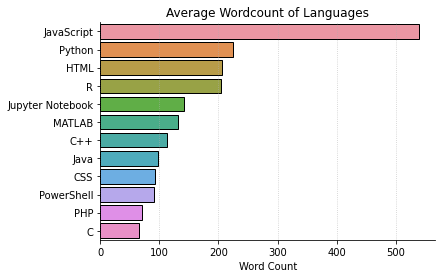

In [22]:
ax = sns.barplot(x=lang_wordcount.values, y=lang_wordcount.index)
ax.set(title='Average Wordcount of Languages', xlabel='Word Count', ylabel='')
plt.show()

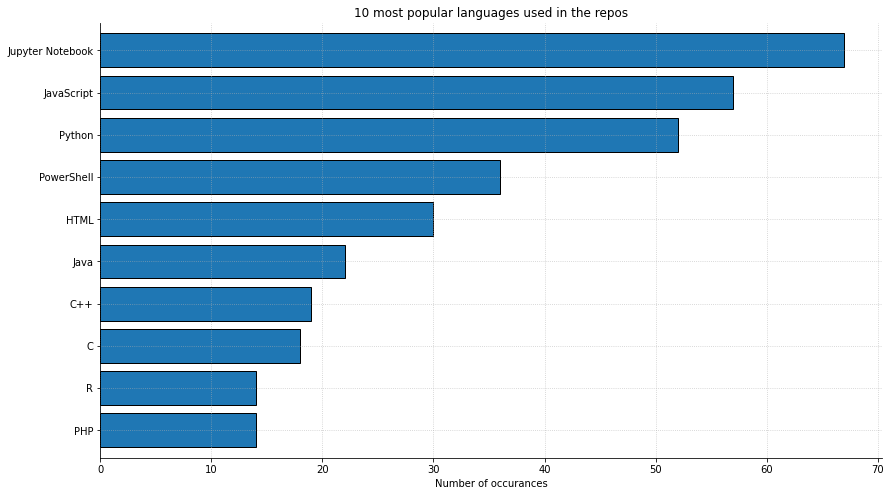

In [23]:
plt.figure(figsize=(14,8))
df.language.value_counts().sort_values(ascending=True).tail(10).plot.barh(width=.8)
plt.title('10 most popular languages used in the repos')
plt.xlabel('Number of occurances')
plt.show()

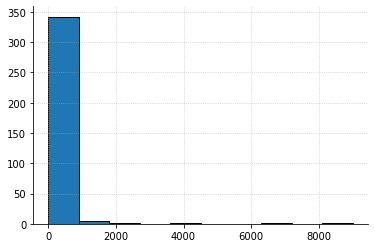

In [24]:
# Does the length of the README vary by programming language?

df.language.value_counts().head(10)
df.groupby('language').word_count.mean().sort_values(ascending=False)
df.word_count.hist()

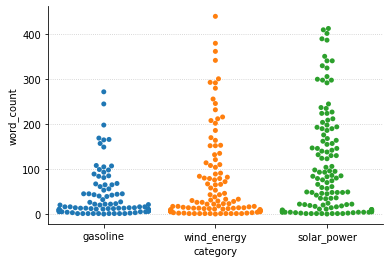

In [25]:
# swarm plot for energy category and README word counts
sns.swarmplot(x=df['category'], y=df[df.word_count < 500].word_count);

In [26]:
# Do different programming languages use a different number of unique words?

# get top 10 popular languages
top_language = list(df.language.value_counts().head(10).index)
top_language
df[df.language.isin(top_language)].language

len(set(df.clean_lemmatized[0].split(' ')))

69

In [27]:
len(set(df[df.language=='Python'].clean_lemmatized.str.cat(sep=' ').split(' ')))

3527

In [28]:
len(set(df[df.language=='Java'].clean_lemmatized.str.cat(sep=' ').split(' ')))

1111

In [29]:
uniques = []
for lang in top_language:
    uniques.append(len(set(df[df.language==lang].clean_lemmatized\
                           .str.cat(sep=' ').split(' '))))
    
pd.Series(uniques, index=top_language).sort_values(ascending=False)

JavaScript          4076
Python              3527
Jupyter Notebook    2850
HTML                1960
PowerShell          1383
R                   1263
Java                1111
C++                 1094
C                    752
PHP                  603
dtype: int64

Text(0.5, 0, 'Number of occurances')

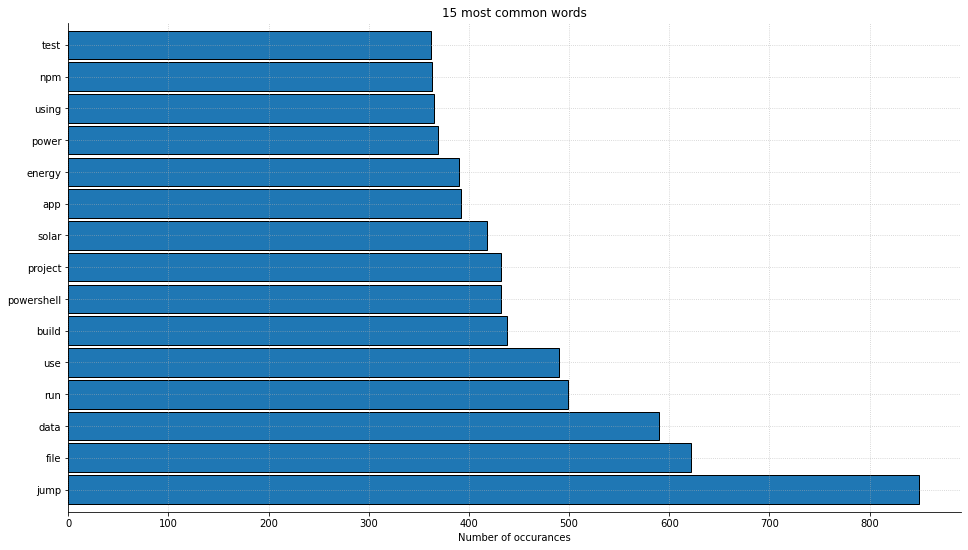

In [30]:
ADDITIONAL_STOPWORDS = ['&#9;']

def clean(text: str) -> list:
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (text.encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split() # tokenization
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

all_words = clean(' '.join(df.readme_contents))

plt.figure(figsize=(16, 9))
pd.Series(all_words).value_counts().head(15).plot.barh(width=.9, ec='black', title='15 most common words')
plt.xlabel('Number of occurances')

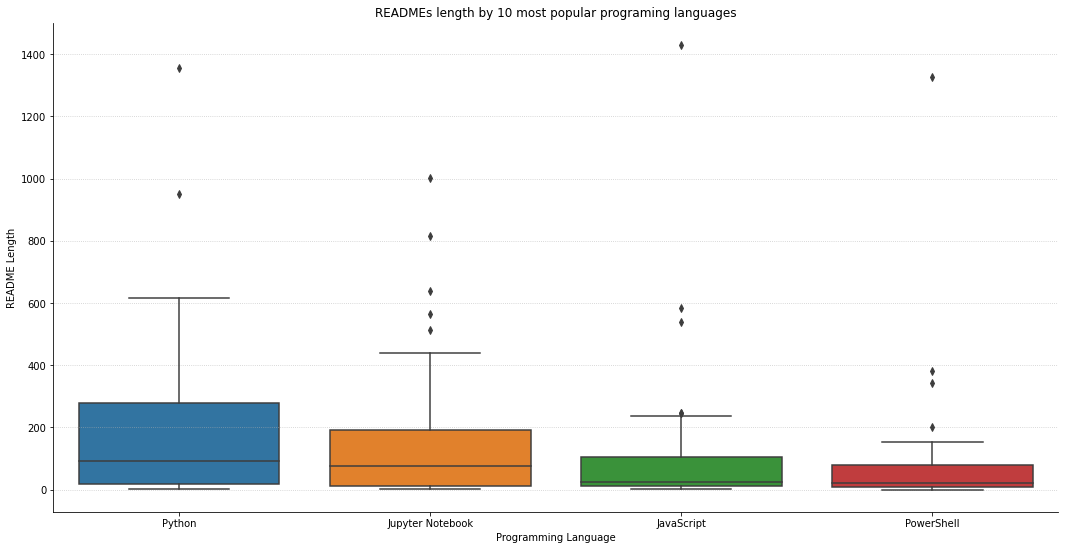

In [31]:
plt.figure(figsize=(18,9))
sns.boxplot(y=top_4_lang_df[top_4_lang_df.word_count < 2000].word_count, x=top_4_lang_df.language)
plt.title("READMEs length by 10 most popular programing languages")
plt.xlabel('Programming Language')
plt.ylabel('README Length')
plt.show()

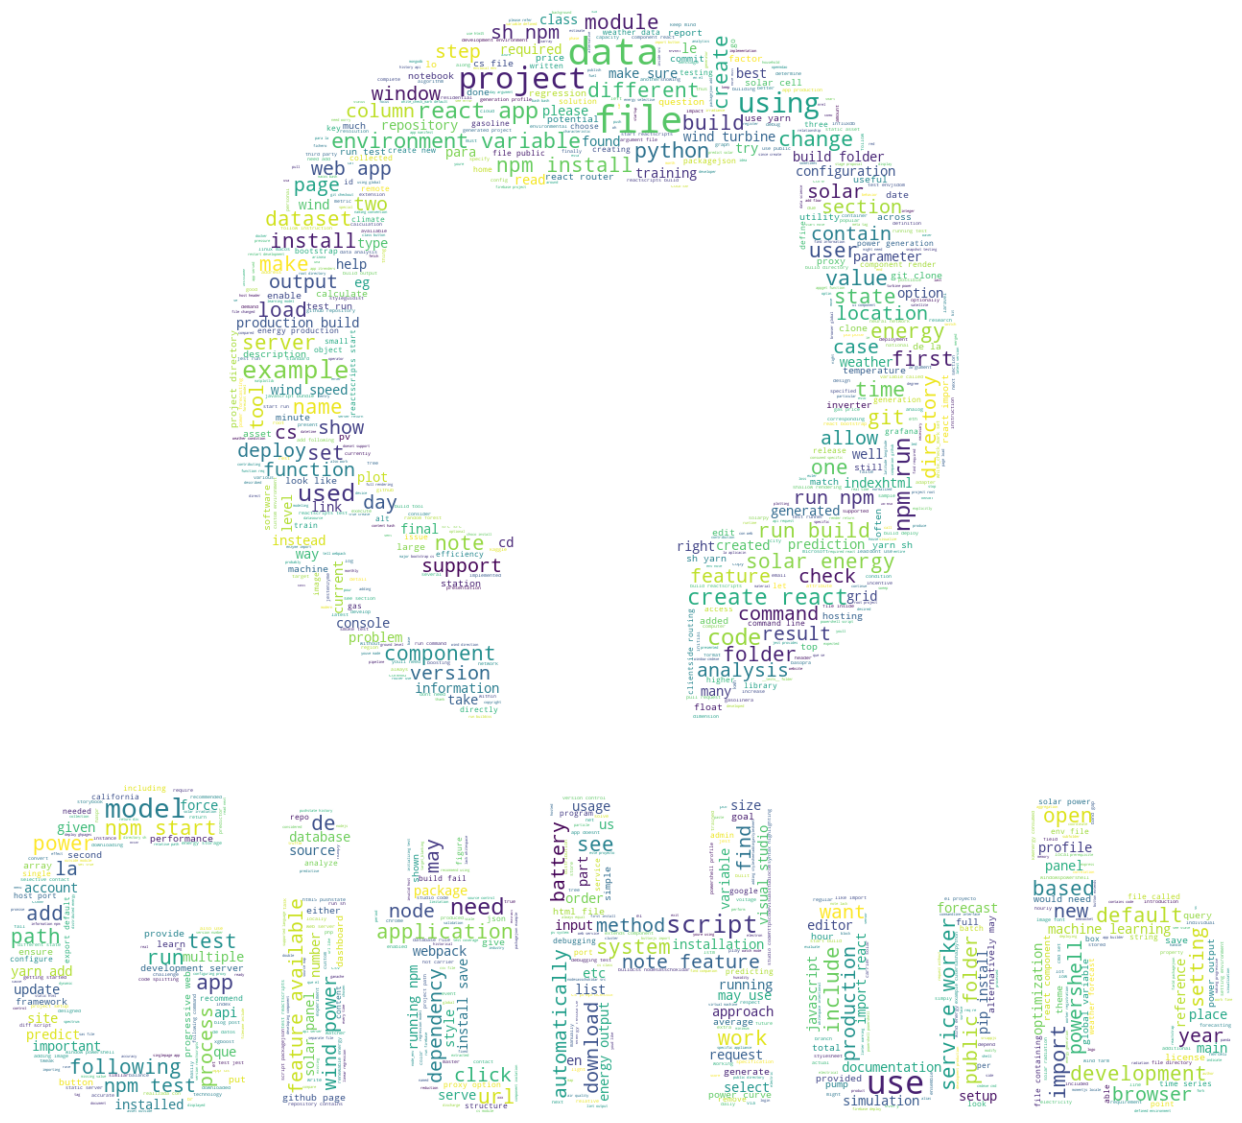

In [32]:
# Let's make a WORD CLOUD for all the words in the top 4 language READMEs

top_4_all_words = clean(' '.join(top_4_lang_df.readme_contents))

def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 
        
        
# Driver code     
top = top_4_all_words

top_str = listToString(top)

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = top_str

# read the mask / color image taken from
top_coloring = np.array(Image.open(path.join(d, "github.png")))
stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color="white", max_words=2000, mask=top_coloring, stopwords=stopwords, max_font_size=40, random_state=42)

# generate word cloud
wc.generate(text)

# create coloring from image
image_colors = ImageColorGenerator(top_coloring)

plt.figure(figsize=(22, 22))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Hypothesis Testing

### Chi2 Test

$H_0$: Using a programming language and being in a specific energy category are independent of each other.
<br>
$H_a$: Using a programming language and being in a specific energy category are dependent on each other.

In [33]:
observed = pd.crosstab(df.category, df.language)
observed

language,C,C++,CSS,HTML,Java,JavaScript,Jupyter Notebook,MATLAB,PHP,PowerShell,Python,R
category,,,,,,,,,,,,
gasoline,6,1,2,12,10,34,12,1,7,0,7,7
solar_power,9,9,8,10,6,18,30,7,7,0,31,3
wind_energy,3,9,0,8,6,5,25,5,0,36,14,4


In [34]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p, degf, expected 
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
print('alpha = 0.01')

Observed

[[ 6  1  2 12 10 34 12  1  7  0  7  7]
 [ 9  9  8 10  6 18 30  7  7  0 31  3]
 [ 3  9  0  8  6  5 25  5  0 36 14  4]]
---
Expected

[[ 5.0625      5.34375     2.8125      8.4375      6.1875     16.03125
  18.84375     3.65625     3.9375     10.125      14.625       3.9375    ]
 [ 7.05681818  7.44886364  3.92045455 11.76136364  8.625      22.34659091
  26.26704545  5.09659091  5.48863636 14.11363636 20.38636364  5.48863636]
 [ 5.88068182  6.20738636  3.26704545  9.80113636  7.1875     18.62215909
  21.88920455  4.24715909  4.57386364 11.76136364 16.98863636  4.57386364]]
---

chi^2 = 152.7753
p     = 0.0000
alpha = 0.01


In [35]:
print(f'''
Because p ({p:.4f}) < alpha (.05),  reject the null hypothesis,
which indicates that using a programming language and being in
a specific energy category are dependent on each other. 
''')


Because p (0.0000) < alpha (.05),  reject the null hypothesis,
which indicates that using a programming language and being in
a specific energy category are dependent on each other. 



### T-Test

$H_0$: There is no difference in README length between Python and Java.
<br>
$H_a$: There is a difference in README length between Python and Java.

In [36]:
df[df.language == 'Python'].word_count.median()
df[df.language == 'Java'].word_count.median()

x1 = df[df.language == 'Python'].word_count
x2 = df[df.language == 'Java'].word_count

alpha = 0.05
tstat, p = stats.ttest_ind(x1, x2)
tstat, p 
print('tstat =', tstat)
print('p =', p)

tstat = 1.4991049537644447
p = 0.13821847174022905


In [37]:
print(f'''
Because p ({p:.4f}) > alpha (.05) , failed to reject the null
hypothesis, which indicate that there is no significant difference
in readme length between repostories using Python and Java. 
''')


Because p (0.1382) > alpha (.05) , failed to reject the null
hypothesis, which indicate that there is no significant difference
in readme length between repostories using Python and Java. 



## Modeling our data

In [38]:
# We'll create a variable for each variable we'll be modeling

documents = df[['repo','language', 'clean_lemmatized']]
documents_top_4 = top_4_lang_df[['repo','language', 'clean_lemmatized']]

### Baseline

In [39]:
# Let's set a baseline model first

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(documents.clean_lemmatized)
y = documents.language

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, stratify=y, random_state=42)
y_train = pd.Series(('Jupyter Notebook,' * X_train.shape[0]).split(',')[:-1])

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

# model = LogisticRegression().fit(X_train, y_train)
model = DecisionTreeClassifier(max_depth=6, random_state=42).fit(X_train, y_train)
# model = RandomForestClassifier(max_depth=6, min_samples_leaf=2, random_state=42).fit(X_train, y_train)
# model = KNeighborsClassifier().fit(X_train, y_train)

train['predicted'] = model.predict(X_train)
test['predicted'] = model.predict(X_test)

print(round(model.score(X_train, y_train), 4))
print(round(model.score(X_test, y_test), 4))

1.0
0.1887


In [40]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(documents_top_4.clean_lemmatized)
y = documents_top_4.language

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, stratify=y, random_state=42)
y_train = pd.Series(('Jupyter Notebook,' * X_train.shape[0]).split(',')[:-1])

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

model = DecisionTreeClassifier(max_depth=6, random_state=42).fit(X_train, y_train)

train['predicted'] = model.predict(X_train)
test['predicted'] = model.predict(X_test)

print(round(model.score(X_train, y_train), 4))
print(round(model.score(X_test, y_test), 4))

1.0
0.3125


### As we'd expect it performs very porrly on the test data for both variables

### All Words - TFIDF

> To use these cells you can unhash whichever model you'd like to run, this works in all model cells
<br>
<br>
> The best performing model per cell has been left unhashed

In [41]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(documents.clean_lemmatized)
y = documents.language

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        train_size=.8, stratify=y, random_state=42)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

# model = LogisticRegression().fit(X_train, y_train)
# model = DecisionTreeClassifier(max_depth=12, random_state=42).fit(X_train, y_train)
model = RandomForestClassifier(max_depth=12, min_samples_leaf=1, random_state=42).fit(X_train, y_train)
# model = KNeighborsClassifier(n_neighbors=15).fit(X_train, y_train)

train['predicted'] = model.predict(X_train)
test['predicted'] = model.predict(X_test)

print(round(model.score(X_train, y_train), 4))
print(round(model.score(X_test, y_test), 4))

0.7402
0.493


### Top 4 - TFIDF

In [42]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(documents_top_4.clean_lemmatized)
y = documents_top_4.language

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        train_size=.8, stratify=y, random_state=42)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

# model = LogisticRegression().fit(X_train, y_train)
# model = DecisionTreeClassifier(max_depth=12, random_state=42).fit(X_train, y_train)
model = RandomForestClassifier(max_depth=12, min_samples_leaf=1, random_state=42).fit(X_train, y_train)
# model = KNeighborsClassifier(n_neighbors=12).fit(X_train, y_train)


train['predicted'] = model.predict(X_train)
test['predicted'] = model.predict(X_test)

print(round(model.score(X_train, y_train), 4))
print(round(model.score(X_test, y_test), 4))

0.9231
0.6047


### All - CountVector

In [43]:
cv = CountVectorizer()
X = cv.fit_transform(documents.clean_lemmatized)
y = documents.language

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        train_size=.8, stratify=y, random_state=42)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

# model = LogisticRegression().fit(X_train, y_train)
# model = DecisionTreeClassifier(max_depth=12, random_state=42).fit(X_train, y_train)
model = RandomForestClassifier(max_depth=12, min_samples_leaf=1, random_state=42).fit(X_train, y_train)
# model = KNeighborsClassifier(n_neighbors=12).fit(X_train, y_train)


train['predicted'] = model.predict(X_train)
test['predicted'] = model.predict(X_test)

print(round(model.score(X_train, y_train), 4))
print(round(model.score(X_test, y_test), 4))

0.7082
0.5211


### Top 4 - CountVector

In [44]:
cv = CountVectorizer()
X = cv.fit_transform(documents_top_4.clean_lemmatized)
y = documents_top_4.language

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        train_size=.8, stratify=y, random_state=42)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

# model = LogisticRegression().fit(X_train, y_train)
# model = DecisionTreeClassifier(max_depth=12, random_state=42).fit(X_train, y_train)
# model = RandomForestClassifier(max_depth=6, min_samples_leaf=2, random_state=42).fit(X_train, y_train)
model = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)


train['predicted'] = model.predict(X_train)
test['predicted'] = model.predict(X_test)

print(round(model.score(X_train, y_train), 4))
print(round(model.score(X_test, y_test), 4))

0.7692
0.6047


### Let's try using some bigrams

In [45]:
tfidf = TfidfVectorizer(ngram_range=(2, 2))
X = tfidf.fit_transform(documents.clean_lemmatized)
y = documents.language

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        train_size=.8, stratify=y, random_state=42)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

# model = LogisticRegression().fit(X_train, y_train)
# model = DecisionTreeClassifier(max_depth=12, random_state=42).fit(X_train, y_train)
model = RandomForestClassifier(max_depth=12, min_samples_leaf=2, random_state=42).fit(X_train, y_train)
# model = KNeighborsClassifier().fit(X_train, y_train)

train['predicted'] = model.predict(X_train)
test['predicted'] = model.predict(X_test)

print(round(model.score(X_train, y_train), 4))
print(round(model.score(X_test, y_test), 4))

0.4377
0.3521


In [46]:
tfidf = TfidfVectorizer(ngram_range=(2, 2))
X = tfidf.fit_transform(documents_top_4.clean_lemmatized)
y = documents_top_4.language

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        train_size=.8, stratify=y, random_state=42)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

# model = LogisticRegression().fit(X_train, y_train)
# model = DecisionTreeClassifier(max_depth=6, random_state=42).fit(X_train, y_train)
model = RandomForestClassifier(max_depth=12, min_samples_leaf=1, random_state=42).fit(X_train, y_train)
# model = KNeighborsClassifier(n_neighbors=9).fit(X_train, y_train)


train['predicted'] = model.predict(X_train)
test['predicted'] = model.predict(X_test)

print(round(model.score(X_train, y_train), 4))
print(round(model.score(X_test, y_test), 4))

0.716
0.4186


In [47]:
cv = CountVectorizer(ngram_range=(2, 2))
X = cv.fit_transform(documents.clean_lemmatized)
y = documents.language

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        train_size=.8, stratify=y, random_state=42)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

model = LogisticRegression().fit(X_train, y_train)
# model = DecisionTreeClassifier(max_depth=12, random_state=42).fit(X_train, y_train)
# model = RandomForestClassifier(max_depth=12, min_samples_leaf=2, random_state=42).fit(X_train, y_train)
# model = KNeighborsClassifier(n_neighbors=9).fit(X_train, y_train)


train['predicted'] = model.predict(X_train)
test['predicted'] = model.predict(X_test)

print(round(model.score(X_train, y_train), 4))
print(round(model.score(X_test, y_test), 4))

0.9359
0.3944


In [48]:
cv = CountVectorizer(ngram_range=(2, 2))
X = cv.fit_transform(documents_top_4.clean_lemmatized)
y = documents_top_4.language

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        train_size=.8, stratify=y, random_state=42)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

model = LogisticRegression().fit(X_train, y_train)
# model = DecisionTreeClassifier(max_depth=11, random_state=42).fit(X_train, y_train)
# model = RandomForestClassifier(max_depth=15, min_samples_leaf=1, random_state=42).fit(X_train, y_train)
# model = KNeighborsClassifier(n_neighbors=9).fit(X_train, y_train)


train['predicted'] = model.predict(X_train)
test['predicted'] = model.predict(X_test)

print(round(model.score(X_train, y_train), 4))
print(round(model.score(X_test, y_test), 4))

0.9645
0.4884


## Executive Summary

> Github READMEs can be good predictors of the programming languages of the repos. With NLP models language is important, so it isn't a surprise that the longer and more in-depth a README is, the better we can get at predicting the primary language.
<br>
<br>
> Whenever possible, words that are unique to a particular programming language, including the name of that language, make for key identifiers of a language.
<br>
<br>
> As with most data work, NLP modeling is no different, imbalances in your data affect everything, most importantly model performance. To improve our models, we'd want to ensure a better language distribution throughout the corpus, and gathering more observations generally speaking will also possitively impact model performace.